Классификация "Есть дефект/Нет дефекта"<br>
Класс с нераспознанным дефектом приравнивается в "Нет дефекта"

# Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import os
from sklearn.model_selection import train_test_split
import shutil
import gc
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from PIL import ImageFile

In [2]:
RANDOM_STATE = 42

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Формирование выборки для обучения


In [5]:
df = pd.read_pickle('../data/common_files/df_markup.pkl')
df = df.loc[
    (df['terminal']==1),
    ['file_name', 'terminal_damaged',
       'terminal_undamaged', 'terminal_unrecognized_defect']
]
df['damaged'] = 0
df.loc[
    df['terminal_damaged']==1,
    'damaged'
] = 1
df = df[['file_name', 'damaged']]
df.sample(5)

,file_name,damaged
3506,..\data\sorted_data_merged\damaged\ЗНО03012917...,1
9784,..\data\sorted_data_merged\undamaged\ЗНО030139...,0
9184,..\data\sorted_data_merged\terminal\╨Ч╨Э╨Ю0301...,0
11474,..\data\sorted_data_merged\undamaged\╨Ч╨Э╨Ю030...,0
10723,..\data\sorted_data_merged\undamaged\╨Ч╨Э╨Ю030...,0


In [6]:
df.shape

(4376, 2)

In [7]:
df['damaged'].value_counts()

damaged
0    3260
1    1116
Name: count, dtype: int64

terminal_damaged:	1


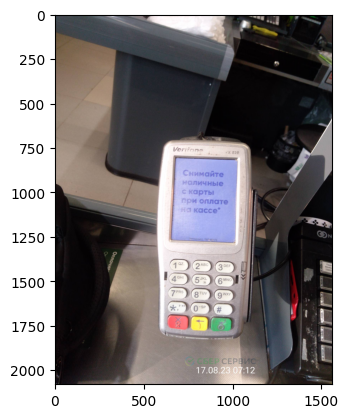

terminal_damaged:	0


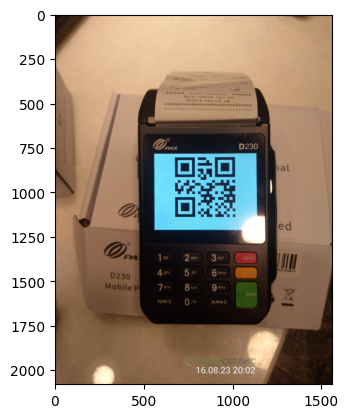

terminal_damaged:	0


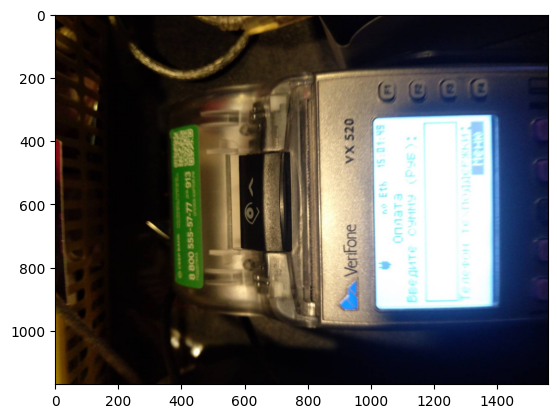

terminal_damaged:	0


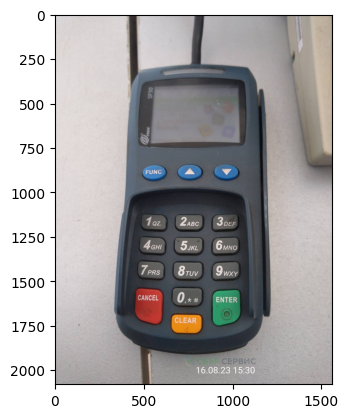

terminal_damaged:	0


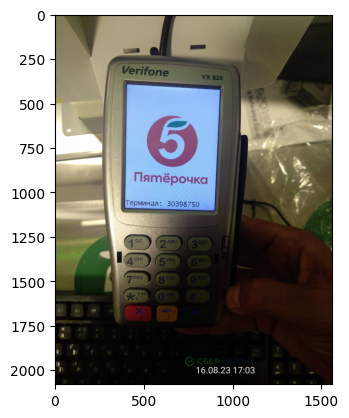

In [8]:
for row in df.sample(5).iterrows():
    row = row[1]
    img = Image.open(row['file_name'])
    print(f'terminal_damaged:\t{row["damaged"]}')
    plt.imshow(img)
    plt.show()

In [9]:
train_data, test_data = train_test_split(
    df, stratify=df['damaged'], test_size=0.25, random_state=RANDOM_STATE
)

In [10]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [11]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, target_column, transform=None):
        self.data = dataframe
        self.transform = transform
        self.target_column = target_column

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.iloc[idx][self.target_column]
        img = Image.open(self.data.iloc[idx]['file_name']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [12]:
NUM_WORKERS = 0 # os.cpu_count()
BATCH_SIZE = 32

train_dataset = CustomDataset(train_data, target_column='damaged', transform=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_dataset = CustomDataset(test_data, target_column='damaged', transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# Обучение модели

In [13]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s):
    clear_output()
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    plt.rcParams['font.size'] = '12'
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    axs[2].plot(range(1, len(train_f1s) + 1), train_f1s, label='train')
    axs[2].plot(range(1, len(test_f1s) + 1), test_f1s, label='test')
    axs[2].set_ylabel('F1')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()
    plt.show()

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy, f1_score_value = 0.0, 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        f1_score_value += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    f1_score_value /= len(train_loader)

    return train_loss, train_accuracy, f1_score_value


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy, test_f1 = 0.0, 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()
        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        test_f1 += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    test_f1 /= len(test_loader)

    return test_loss, test_accuracy, test_f1


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies, train_f1s = [], [], []
    test_losses, test_accuracies, test_f1s = [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy, train_f1 = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy, test_f1 = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        train_f1s += [train_f1]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        test_f1s += [test_f1]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s)

    return train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s

In [14]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [15]:
num_epochs = 30

model_terminal = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
model_terminal.classifier[1] = torch.nn.Linear(1280, 2)
model_terminal = model_terminal.to(device)
optimizer = torch.optim.SGD(model_terminal.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

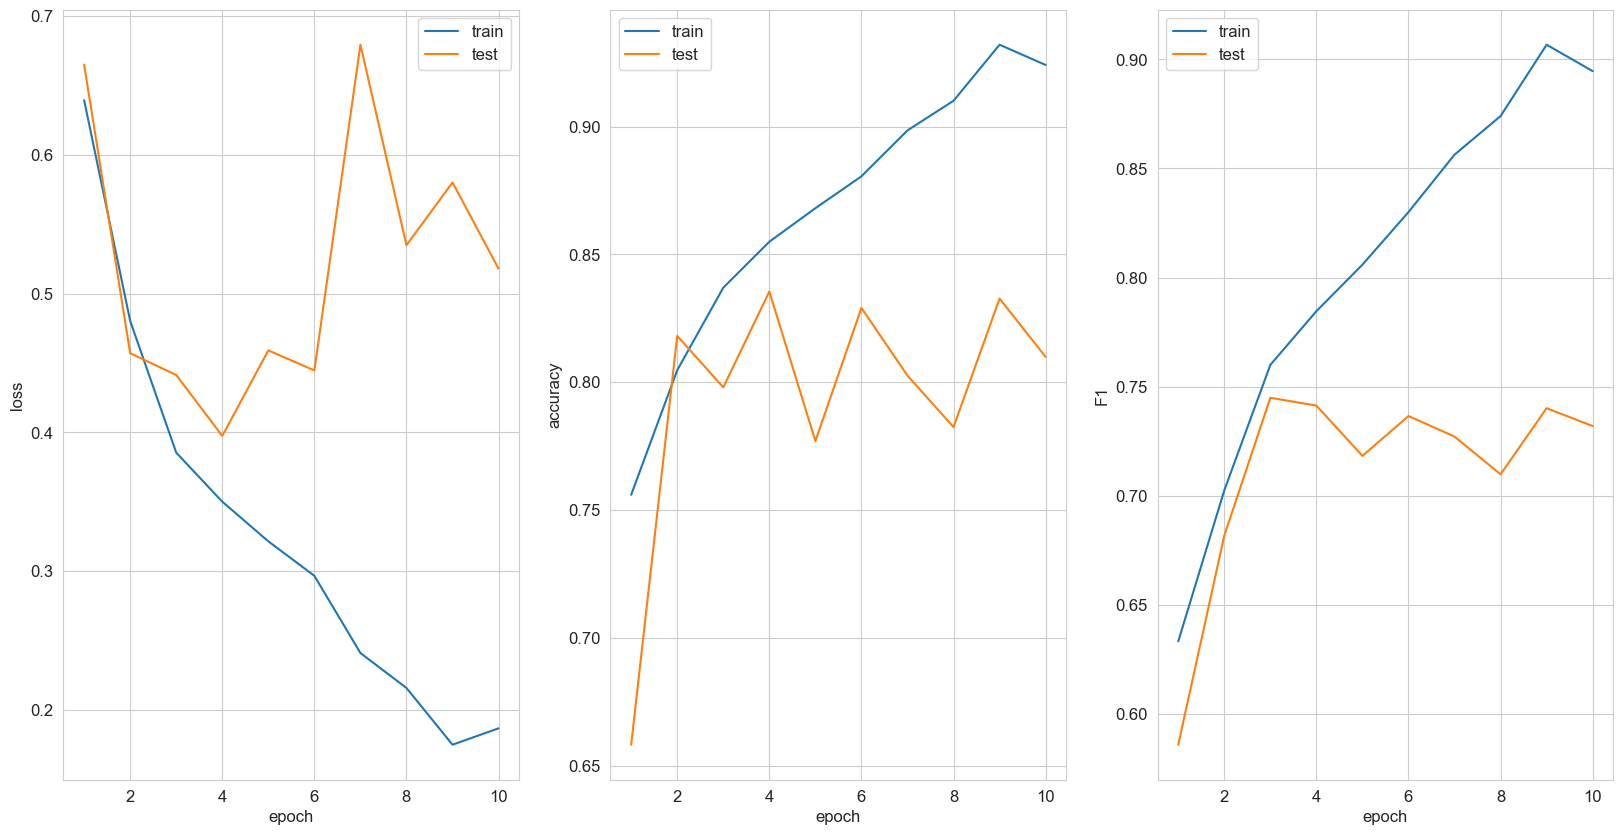

Training 11/30:   5%|▍         | 5/103 [00:03<01:17,  1.26it/s]


KeyboardInterrupt: 

In [16]:
train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s = train(
    model_terminal, optimizer, scheduler, criterion, train_dataloader, test_dataloader, num_epochs
)